In [2]:
train_folder = 'C:\\Users\\Haritha shree\\Downloads\\Lung-Cancer-Prediction-using-CNN-and-Transfer-Learning\\dataset\\train'
test_folder = 'C:\\Users\\Haritha shree\\Downloads\\Lung-Cancer-Prediction-using-CNN-and-Transfer-Learning\\dataset\\test'
validate_folder = 'C:\\Users\\Haritha shree\\Downloads\\Lung-Cancer-Prediction-using-CNN-and-Transfer-Learning\\dataset\\valid'


In [3]:
# Define paths to the specific classes within the dataset
normal_folder = '/normal'
adenocarcinoma_folder = '/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib'
large_cell_carcinoma_folder = '/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa'
squamous_cell_carcinoma_folder = '/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa'


In [1]:
# Import necessary libraries
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

In [1]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout2D, Activation, Lambda, Flatten, LSTM
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import utils

In [32]:
IMAGE_SIZE = (224, 224)
# Initialize the image data generators for training and testing
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

# Define the batch size for training
batch_size = 8
train_folder = 'C:\\Users\\Haritha shree\\Downloads\\Lung-Cancer-Prediction-using-CNN-and-Transfer-Learning\\dataset\\train'
test_folder = 'C:\\Users\\Haritha shree\\Downloads\\Lung-Cancer-Prediction-using-CNN-and-Transfer-Learning\\dataset\\test'
# Create the training data generator
train_generator = train_datagen.flow_from_directory(
    train_folder,
    target_size=IMAGE_SIZE,
    batch_size=8,
    color_mode="rgb",
    class_mode='categorical'
)

# Create the validation data generator
validation_generator = test_datagen.flow_from_directory(
    test_folder,
    target_size=IMAGE_SIZE,
    batch_size=8,
    color_mode="rgb",
    class_mode='categorical'
)

Found 613 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


In [41]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Parameters
img_height, img_width = 224, 224
batch_size = 32
num_classes = 4  # Adjust this to your number of classes

# Base Model
Xception_base = tf.keras.applications.Xception(
    input_shape=(img_height, img_width, 3),
    include_top=False,
    weights="imagenet"
)

# Freeze the base model layers
for layer in Xception_base.layers:
    layer.trainable = False

# Custom Model Definition
Xception = tf.keras.Sequential([
    Xception_base,
    layers.Dropout(0.5),
    layers.Flatten(),
    layers.BatchNormalization(),
    layers.Dense(32, kernel_initializer='he_uniform'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),
    layers.Dense(32, kernel_initializer='he_uniform'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')  # Change to softmax for multi-class
])

# Model Compilation
Xception.compile(optimizer='rmsprop',
                 loss='categorical_crossentropy',  # Use categorical_crossentropy for multi-class
                 metrics=['accuracy'])

# Callbacks
lrd = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.50, min_lr=1e-7)
mcp = tf.keras.callbacks.ModelCheckpoint('Xception.h5', save_best_only=True, monitor='val_accuracy')
es = tf.keras.callbacks.EarlyStopping(verbose=1, patience=3)

# Model Training
history = Xception.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=36,
    verbose=1,
    callbacks=[lrd, mcp, es],
    shuffle=True
)

# Model Evaluation
loss, accuracy = Xception.evaluate(validation_generator)
print(f'Validation Accuracy: {accuracy:.2f}')


Epoch 1/36
 6/20 [========>.....................] - ETA: 39s - loss: 1.7659 - accuracy: 0.3229

KeyboardInterrupt: 

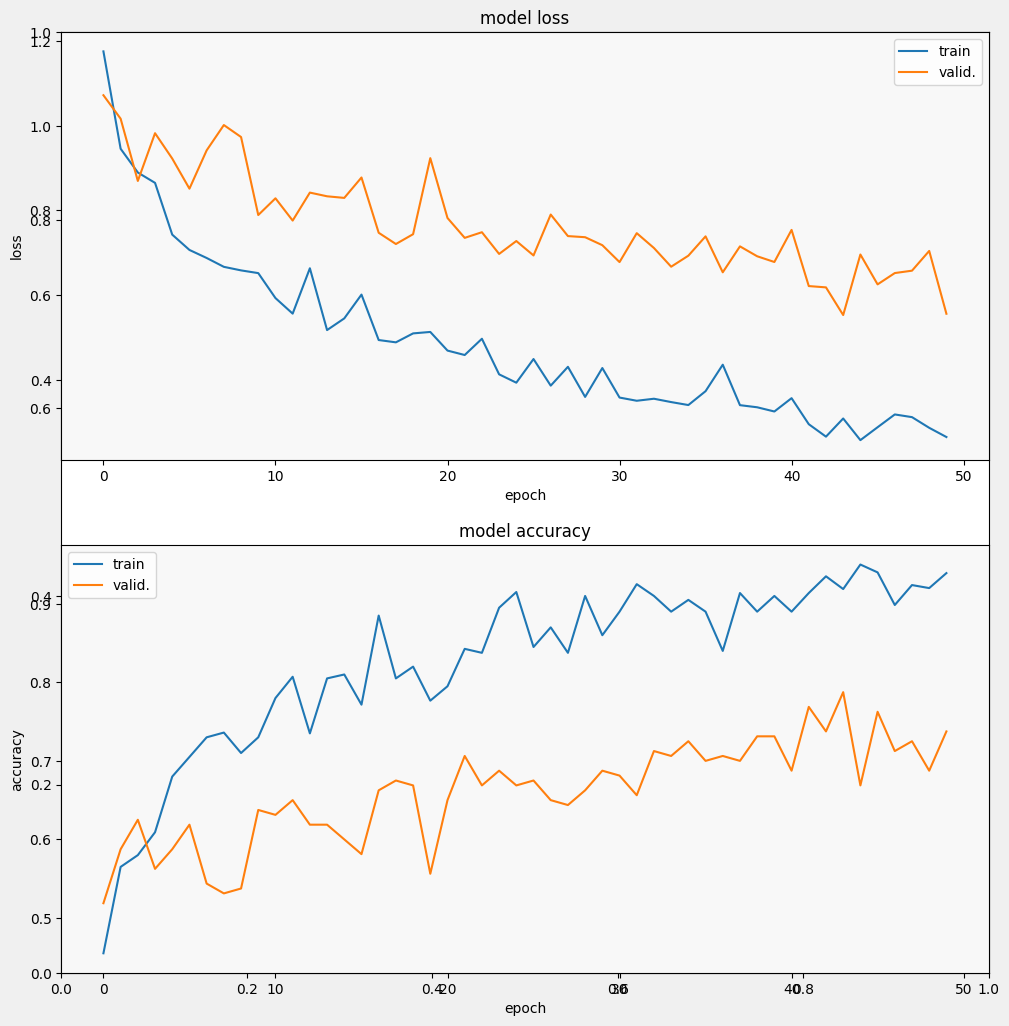

In [7]:
import matplotlib.pyplot as plt

# Function to display training curves for loss and accuracy
def display_training_curves(training, validation, title, subplot):
    if subplot % 10 == 1:
        plt.subplots(figsize=(10, 10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model ' + title)
    ax.set_ylabel(title)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

# Display training curves for loss and accuracy
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 211)
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 212)


In [9]:
# Save the trained model
model.save('C:\\Users\\Haritha shree\\Downloads\\Lung-Cancer-Prediction-using-CNN-and-Transfer-Learning\\trained_lung_cancer_model.h5')


c:\Users\Haritha shree\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 1s 1s/step
The image belongs to class: large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa


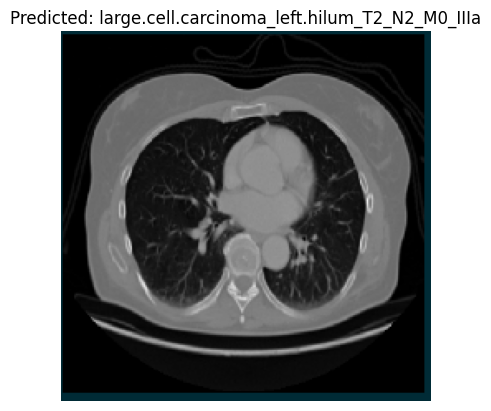

In [12]:
# Function to load and preprocess an image for prediction
from tensorflow.keras.preprocessing import image
import numpy as np

# Define a function to load and preprocess the image
def load_and_preprocess_image(img_path, target_size):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Rescale the image like the training images
    return img_array

# Load, preprocess, and predict the class of an image
img_path = 'C:\\Users\\Haritha shree\\Downloads\\Lung-Cancer-Prediction-using-CNN-and-Transfer-Learning\\sq.png'
img = load_and_preprocess_image(img_path, IMAGE_SIZE)

# Make a prediction
predictions = model.predict(img)
predicted_class = np.argmax(predictions[0])

# Map the predicted class to the class label
class_labels = list(train_generator.class_indices.keys())
predicted_label = class_labels[predicted_class]

# Print the predicted class
print(f"The image belongs to class: {predicted_label}")

# Display the image with the predicted class
plt.imshow(image.load_img(img_path, target_size=IMAGE_SIZE))
plt.title(f"Predicted: {predicted_label}")
plt.axis('off')
plt.show()


1/1 [==============================] - 0s 149ms/step
The image belongs to class: normal


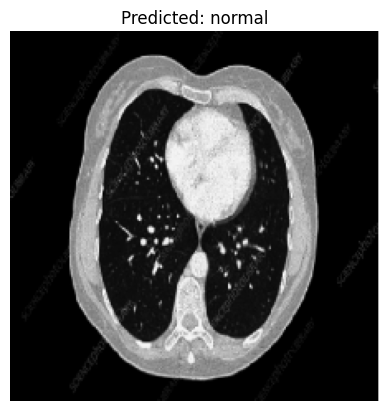

In [13]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Define a function to load and preprocess the image
def load_and_preprocess_image(img_path, target_size):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Rescale the image like the training images
    return img_array

# Load an image from your drive
img_path = 'C:\\Users\\Haritha shree\\Downloads\\Lung-Cancer-Prediction-using-CNN-and-Transfer-Learning\\test1.png'
img = load_and_preprocess_image(img_path, IMAGE_SIZE)

# Make a prediction
predictions = model.predict(img)
predicted_class = np.argmax(predictions[0])

# Map the predicted class to the class label
class_labels = list(train_generator.class_indices.keys())
predicted_label = class_labels[predicted_class]

# Print the predicted class
print(f"The image belongs to class: {predicted_label}")

# Display the image
plt.imshow(image.load_img(img_path, target_size=IMAGE_SIZE))
plt.title(f"Predicted: {predicted_label}")
plt.axis('off')
plt.show()
